# Decision Tree Lab

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

## 1. (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  
### Code Requirements/Notes:
- Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits. Otherwise, even with approaches like pruning below, the SSE type of overfit could still hurt us.) 
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use a simple data set (like the lenses data or the pizza homework), which you can check by hand, to test your algorithm to make sure that it is working correctly. 

In [2]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self,data):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """
        self.tree=None
        self.original_data=data
        self.data=data
        self.features=data.columns[:-1]
        self.target=data.columns[-1]
        self.split_info_gain = []

    def fit(self, X, y, data, features, parent=None):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        
        if len(features) == 0:
            return parent
        
        n = np.unique(data[self.target])
        if len(n) <= 1:
            return n[0]
#       if len(data) == 0:        
        else:
                        
            target_counts = np.unique(data[self.target], return_counts=True)[1] # counts
            max_target_count = np.argmax(target_counts)                         
            parent = np.unique(data[self.target])[max_target_count]
            
            informations=[]
            for i in features:
                informations.append(self.get_gain(data, i))
            best_attribute_index = np.argmax(informations)
            best_attribute = features[best_attribute_index]
            
            self.split_info_gain.append(informations[best_attribute_index])  # best split_info_gain found here
            #print(informations[best_attribute_index])
            
            # dict tree
            dt = {best_attribute: {}}
        
            updated_features = []
            for i in features:
                if i != best_attribute:
                    updated_features.append(i)
                    
            for decision in np.unique(data[best_attribute]):
                temp = decision
                child_data = data.where(data[best_attribute] == temp).dropna()
                child_tree = self.fit(X, y, child_data, updated_features, parent)
                dt[best_attribute][temp] = child_tree
            self.tree = dt
            return dt
          
    
    
    def get_entropy(self, col):
        n, counts = np.unique(col, return_counts = True)
        info_s = 0
        for i in range(len(n)):
            info_s += (-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts))
        entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(n))])
        return info_s
    
    def get_gain(self, data, col):
        info_s = self.get_entropy(data[self.target])
        n, counts = np.unique(data[col], return_counts = True)
#         info = 0
#         for i in range(len(n)):
#             temp = self.get_entropy(data.where(data[col] == n[i])).dropna()[self.target]
#             print(temp)
#             info += (counts[i]/np.sum(counts))*temp
        info = np.sum([(counts[i]/np.sum(counts))*self.get_entropy(data.where(data[col]==n[i]).dropna()[self.target]) for i in range(len(n))])
        info_gain = info_s - info
        return info_gain
        

    def predict(self, X, tree):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        
        pred = []
        
        # test cases
        for i in range(len(X)):
            curr_x = X[i]
            t = self.predict_helper(curr_x, tree)
            pred.append(t)
        return pred
        
    def get_index(self, feature):
        for i in range(len(self.features)):
            if feature == self.features[i]:
                return [i]
    
    def predict_helper(self, curr_x, tree):
        curr_node = list(tree.keys())
        for feature in self.features:
            if feature in curr_node:
                index = self.get_index(feature)
                try:
                    low_tree = tree[feature][curr_x[index][0]] #exception occurs, why?????
                except:
                    # key not in the tree
                    return None 
                if type(low_tree) == str:  # leaf
                    return low_tree
                next_key = list(low_tree.keys())
                next_key = next_key[0]
                if low_tree[next_key] is not None:
                    return self.predict_helper(curr_x, low_tree)
                else:
                    return low_tree
        

    def score(self, X, y, tree):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        pred = self.predict(X, tree)
        
        score = 0
        for i in range(len(pred)):
            if pred[i] == y[i]:
                score += 1
        
        return round(score/len(pred), 2)

## 1.1 Debug

Debug your model by training on the lenses dataset: [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff)

Test your model on the lenses test set: [Debug Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff)

Parameters:
(optional) counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)

---

Expected Results: Accuracy = [0.33]

Predictions should match this file: [Lenses Predictions](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv)

Split Information Gains (These do not need to be in this exact order):

[0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits should look like, and the corresponding child node predictions:

Decision Tree:
<pre>
feature_3 = 0:
	feature_2 = 0:
		feature_0 = 0:
			prediction: 2
		feature_0 = 1:
			feature_1 = 0:
				prediction: 2
			feature_1 = 1:
				prediction: 1
		feature_0 = 2:
			prediction: 2
	feature_2 = 1:
		feature_1 = 0:
			feature_0 = 0:
				prediction: 1
			feature_0 = 1:
				prediction: 1
			feature_0 = 2:
				prediction: 0
		feature_1 = 1:
			prediction: 0
feature_3 = 1:
	prediction: 1
</pre>

In [3]:
# Load debug training data 
from scipy.io import arff
import pandas as pd

# Load debug data
lenses = arff.loadarff("lenses.arff")
lenses_df = pd.DataFrame(lenses[0])

str_df = lenses_df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    lenses_df[col]=str_df[col]
lenses_np = np.array(lenses_df)
X = lenses_np[:,-1]
y = lenses_np[:-1]
lenses_df

# Train Decision Tree
dt_debug = DTClassifier(lenses_df)
tree = dt_debug.fit(X,y,lenses_df,lenses_df.columns[:-1])
print("Debug Data DT: \n")
pprint(dt_debug.tree)
print("\n")
# Load debug test data

lenses_test = arff.loadarff("lenses_test.arff")
lenses_test_df = pd.DataFrame(lenses_test[0])
str_df = lenses_test_df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    lenses_test_df[col]=str_df[col]

# Predict and compute model accuracy
np_test = np.array(lenses_test_df)
X_test = np_test[:,:-1]
y_test = np_test[:,-1]

print("Accuracy: ", dt_debug.score(X_test, y_test, tree), "\n")

# Print the information gain of every split you make.
print("Split information gain: ")
print("\t", dt_debug.split_info_gain)

Debug Data DT: 

{'tear_prod_rate': {'normal': {'astigmatism': {'no': {'age': {'pre_presbyopic': 'soft',
                                                              'presbyopic': {'spectacle_prescrip': {'hypermetrope': 'none',
                                                                                                    'myope': 'none'}},
                                                              'young': 'soft'}},
                                               'yes': {'spectacle_prescrip': {'hypermetrope': {'age': {'pre_presbyopic': 'none',
                                                                                                       'presbyopic': 'none',
                                                                                                       'young': 'none'}},
                                                                              'myope': 'hard'}}}},
                    'reduced': 'none'}}


Accuracy:  0.33 

Split information gain: 
	 [0.548794

In [4]:
# Optional/Additional Debugging Dataset - Pizza Homework
# pizza_dataset = np.array([[1,2,0],[0,0,0],[0,1,1],[1,1,1],[1,0,0],[1,0,1],[0,2,1],[1,0,0],[0,2,0]])
# pizza_labels = np.array([2,0,1,2,1,2,1,1,0])

## 1.2 Evaluation

We will evaluate your model based on its performance on the zoo dataset. 

Train your model using this dataset: [Evaluation Train Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff)

Test your model on this dataset: [Evaluation Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff)

Parameters:
(optional) counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)

---
Print out your accuracy on the evaluation test dataset.

Print out the information gain of every split you make.

In [6]:
# Load evaluation training data
zoo = arff.loadarff("zoo.arff")
zoo_df = pd.DataFrame(zoo[0])

str_df = zoo_df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    zoo_df[col]=str_df[col]
zoo_np = np.array(zoo_df)
X = zoo_np[:,-1]
y = zoo_np[:-1]

# Train Decision Tree
dt_eval = DTClassifier(zoo_df)
zoo_tree = dt_eval.fit(X,y,zoo_df,zoo_df.columns[:-1])

# Load evaluation test data
zoo_test = arff.loadarff("zoo_test.arff")
zoo_test_df = pd.DataFrame(zoo_test[0])

str_df = zoo_test_df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    zoo_test_df[col]=str_df[col]
zoo_test_np = np.array(zoo_test_df)
X_test = zoo_test_np[:,:-1]
y_test = zoo_test_np[:,-1]

print("Accuracy score: ", dt_eval.score(X_test, y_test, zoo_tree))

# Print out the information gain for every split you make
pprint(zoo_tree)
print(dt_eval.split_info_gain)

Accuracy score:  0.15
{'legs': {'0': {'fins': {'F': {'toothed': {'F': 'c7', 'T': 'c3'}},
                         'T': {'eggs': {'F': 'cT', 'T': 'c4'}}}},
          '2': {'hair': {'F': 'c2', 'T': 'cT'}},
          '4': {'hair': {'F': {'predator': {'F': 'c3',
                                            'T': {'toothed': {'F': 'c7',
                                                              'T': 'c5'}}}},
                         'T': 'cT'}},
          '5': 'c7',
          '6': {'predator': {'F': 'c6', 'T': 'c7'}},
          '8': 'c7'}}
[1.3630469031539394, 0.8865408928220899, 0.9852281360342515, 0.6962122601251458, 0.8256265261578954, 0.6892019851173654, 0.8631205685666308, 0.7219280948873623, 0.7219280948873623]


## 2. (20%) You will use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criteria, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, report the training and test classification accuracy for each fold and the average test accuracy. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

## 2.1 Implement 10-fold Cross Validation

In [7]:
# Write a function that implements 10-fold cross validation
def cv_ten_fold(df):
    # shuffle the data
    df = df.sample(frac=1).reset_index(drop=True)
    
    # split the data into ten groups
    num_rows = df.shape[0]
    n = num_rows//10
    folds=[]
    _from = 0
    to = 0
    for i in range(10):
        to += n
        folds.append(df.iloc[_from:to])
        _from = to
    
    test_acc=[]
    train_acc=[]
    for i in range(10):
        temp_df = df.copy()
        
        held_out_data = folds[i]
        rest_data = temp_df.drop(temp_df.index[i*n:i*n+n])
        
        np_rest = np.array(rest_data)
        X = np_rest[:,:-1]
        y = np_rest[:,-1]
        
        np_test = np.array(held_out_data)
        X_test = np_test[:,:-1]
        y_test = np_test[:,-1]
        
        dt = DTClassifier(rest_data)
        tree = dt.fit(X,y,rest_data, rest_data.columns[:-1])
        test_acc.append(dt.score(X_test, y_test, tree))
        train_acc.append(dt.score(X,y,tree))
    return test_acc, train_acc, dt

##  2.2 Cars Dataset
- Use this [Cars Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff)

In [8]:
# Use 10-fold CV on Cars Dataset
car = arff.loadarff("cars.arff")
car_df = pd.DataFrame(car[0])
str_df = car_df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    car_df[col]=str_df[col]

# Report Training and Test Classification Accuracies
test_acc, train_acc, dt_car = cv_ten_fold(car_df)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)
# Report Average Test Accuracy
print("Average test accuracy: ", round(sum(test_acc)/10,2))

Training accuracy:  [0.97, 0.97, 0.96, 0.97, 0.96, 0.97, 0.96, 0.96, 0.97, 0.97]
Test accuracy:  [0.89, 0.88, 0.88, 0.91, 0.91, 0.84, 0.88, 0.91, 0.88, 0.89]
Average test accuracy:  0.89


## 2.3 Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Note that you will need to support unknown attributes in the voting data set. 

In [11]:
# Used 10-fold CV on Voting Dataset
vote = arff.loadarff("voting.arff")
vote_df = pd.DataFrame(vote[0])
str_df = vote_df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    vote_df[col]=str_df[col]

# Report Training and Test Classification Accuracies
vote_df = vote_df.replace(['?'], np.nan)
vote_df = vote_df.apply(lambda x: x.fillna(x.value_counts().index[0]))

test_acc, train_acc, dt_vote = cv_ten_fold(vote_df)
print("Training accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

# Report Average Test Accuracy
print("Average test accuracy: ", round(sum(test_acc)/10,2))

Training accuracy:  [0.99, 0.99, 0.99, 0.99, 1.0, 0.99, 0.99, 1.0, 0.99, 1.0]
Test accuracy:  [0.98, 0.95, 0.93, 0.95, 0.88, 0.98, 0.93, 0.95, 0.93, 0.93]
Average test accuracy:  0.94


## 2.4 Discuss Your Results

- Summarize your results from both datasets, and discuss what you observed. 
- A fully expanded tree will often get 100% accuracy on the training set. Why does this happen and in what cases might it not?  

I used 10-fold cross validation on both datasets. For the car dataset, the average test accruacy was a little bit lower than the expected results. It was about 89% on average.
For the voting dataset, the average test accuracy was about 94% which was expected. One thing to note was that the test accruacy was almost 100% for this dataset.
I think that's what a fully expanded tree will often result in because the training dataset has all the information that the tree needs.

## 3. (15%) For each of the two problems above, summarize in English what the decision tree has learned (i.e. look at the induced tree and describe what rules it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

## 3.1 Discuss what the decision tree induced on the cars dataset has learned

As shown in the tree, "safety" feature was found to be the most important feature in the car dataset, so it's placed in the top root node. That means, we can obtain the most information from the safety feature than that from other features. The top feature has three values, high, low, and med, and it seems that the low value has the leaf node of unacc output class. For the other two values, the tree used "person" feature to grow its branches to learn to classify. 

In [12]:
pprint(dt_car.tree)

{'safety': {'high': {'persons': {'2': 'unacc',
                                 '4': {'buying': {'high': {'maint': {'high': 'acc',
                                                                     'low': 'acc',
                                                                     'med': 'acc',
                                                                     'vhigh': 'unacc'}},
                                                  'low': {'maint': {'high': {'lug_boot': {'big': 'vgood',
                                                                                          'med': {'doors': {'2': 'acc',
                                                                                                            '3': 'acc',
                                                                                                            '4': 'acc',
                                                                                                            '5more': 'acc'}},
                      

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

For the voting dataset, the top feature in the root node is "physician-fee-freeze". When we have a data that we want to classify with these features, we can gain the most information by asking about "physician-fee-freeze" feature. The next value was originally '?", but it was imputed as 'n' in this case. For 'no' in the next level, the best attribute found was 'duty-free-exports', and so on. The tree kept growing until they reached the leaf nodes.

In [13]:
pprint(dt_vote.tree)

{'physician-fee-freeze': {'n': {'synfuels-corporation-cutback': {'n': {'crime': {'n': {'anti-satellite-test-ban': {'n': {'education-spending': {'n': 'democrat',
                                                                                                                                                'y': 'republican'}},
                                                                                                                   'y': 'democrat'}},
                                                                                 'y': {'anti-satellite-test-ban': {'n': 'democrat',
                                                                                                                   'y': {'el-salvador-aid': {'n': {'adoption-of-the-budget-resolution': {'n': {'handicapped-infants': {'n': 'democrat',
                                                                                                                                                                                

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

Instead of throwing out data with unknown attributes, I found the most frequent value in each feature. This might not be a good idea since this dataset has only two values, yes and no, but I thought it would be better to impute the unknown attributes with the most common values rather than treating them as their own values. 

## 4.1 (10%) Use SciKit Learn's decision tree on the voting dataset and compare your results. Try different parameters and report what parameters perform the best on the test set. 

### 4.1.1 SK Learn on Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Use SK Learn's Decision Tree to learn the voting dataset
vote = arff.loadarff("voting.arff")
vote_df = pd.DataFrame(vote[0])
str_df = vote_df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    vote_df[col]=str_df[col]
vote_df = vote_df.replace(['?'], np.nan)
vote_df = vote_df.apply(lambda x: x.fillna(x.value_counts().index[0]))
#np_vote = onehot_encoder.fit_transform(vote_df)


vote_df = vote_df.apply(LabelEncoder().fit_transform)
np_vote = np.array(vote_df)
X = np_vote[:,:-1]
y = np_vote[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Explore different parameters
clf = DecisionTreeClassifier(criterion='gini', splitter='random', max_leaf_nodes=10)
clf.fit(X_train, y_train)

# Report results
y_pred = clf.predict(X_test)
print("<Voting dataset accuracy score>")
round(metrics.accuracy_score(y_test, y_pred),2)

<Voting dataset accuracy score>


0.97

The default criterion for sklearn's DTClassifier was Gini impurity instead of entropy of information gain. Apparently it was much faster and more accurate than my method. As I built my decision tree, I'm still not sure how to deal with the exception that occurs while searching down the tree when predicting, and maybe there are other unknown errors in my method. I tried random splitting instead of choosing the best feature, and maximum leaf nodes.   

## 4.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the SK decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [15]:
# Use SciKit Learn's Decision Tree on a new dataset
adult_df = pd.read_csv("adult.data")

adult_df_transform = adult_df.apply(LabelEncoder().fit_transform)

adult_np = np.array(adult_df_transform)
X = adult_np[:,:-1]
y = adult_np[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf2 = DecisionTreeClassifier(criterion="entropy")
clf2.fit(X_train, y_train)
print("<Adult dataset accuracy score>")
round(metrics.accuracy_score(y_test, clf2.predict(X_test)),2)

<Adult dataset accuracy score>


0.81

In [16]:
adult_df_transform

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,33,6,2925,9,12,2,4,0,4,1,0,0,12,39,0
1,21,4,14085,11,8,0,6,1,4,1,0,0,39,39,0
2,36,4,15335,1,6,2,6,0,2,1,0,0,39,39,0
3,11,4,19354,9,12,2,10,5,2,0,0,0,39,5,0
4,20,4,17699,12,13,2,4,5,4,0,0,0,39,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,10,4,16527,7,11,2,13,5,4,0,0,0,37,39,0
32556,23,4,8079,11,8,2,7,0,4,1,0,0,39,39,1
32557,41,4,7882,11,8,6,1,4,4,0,0,0,39,39,0
32558,5,4,12880,11,8,4,1,3,4,1,0,0,19,39,0


## 6. (5%) Visualize your decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first several levels (e.g. top 5).

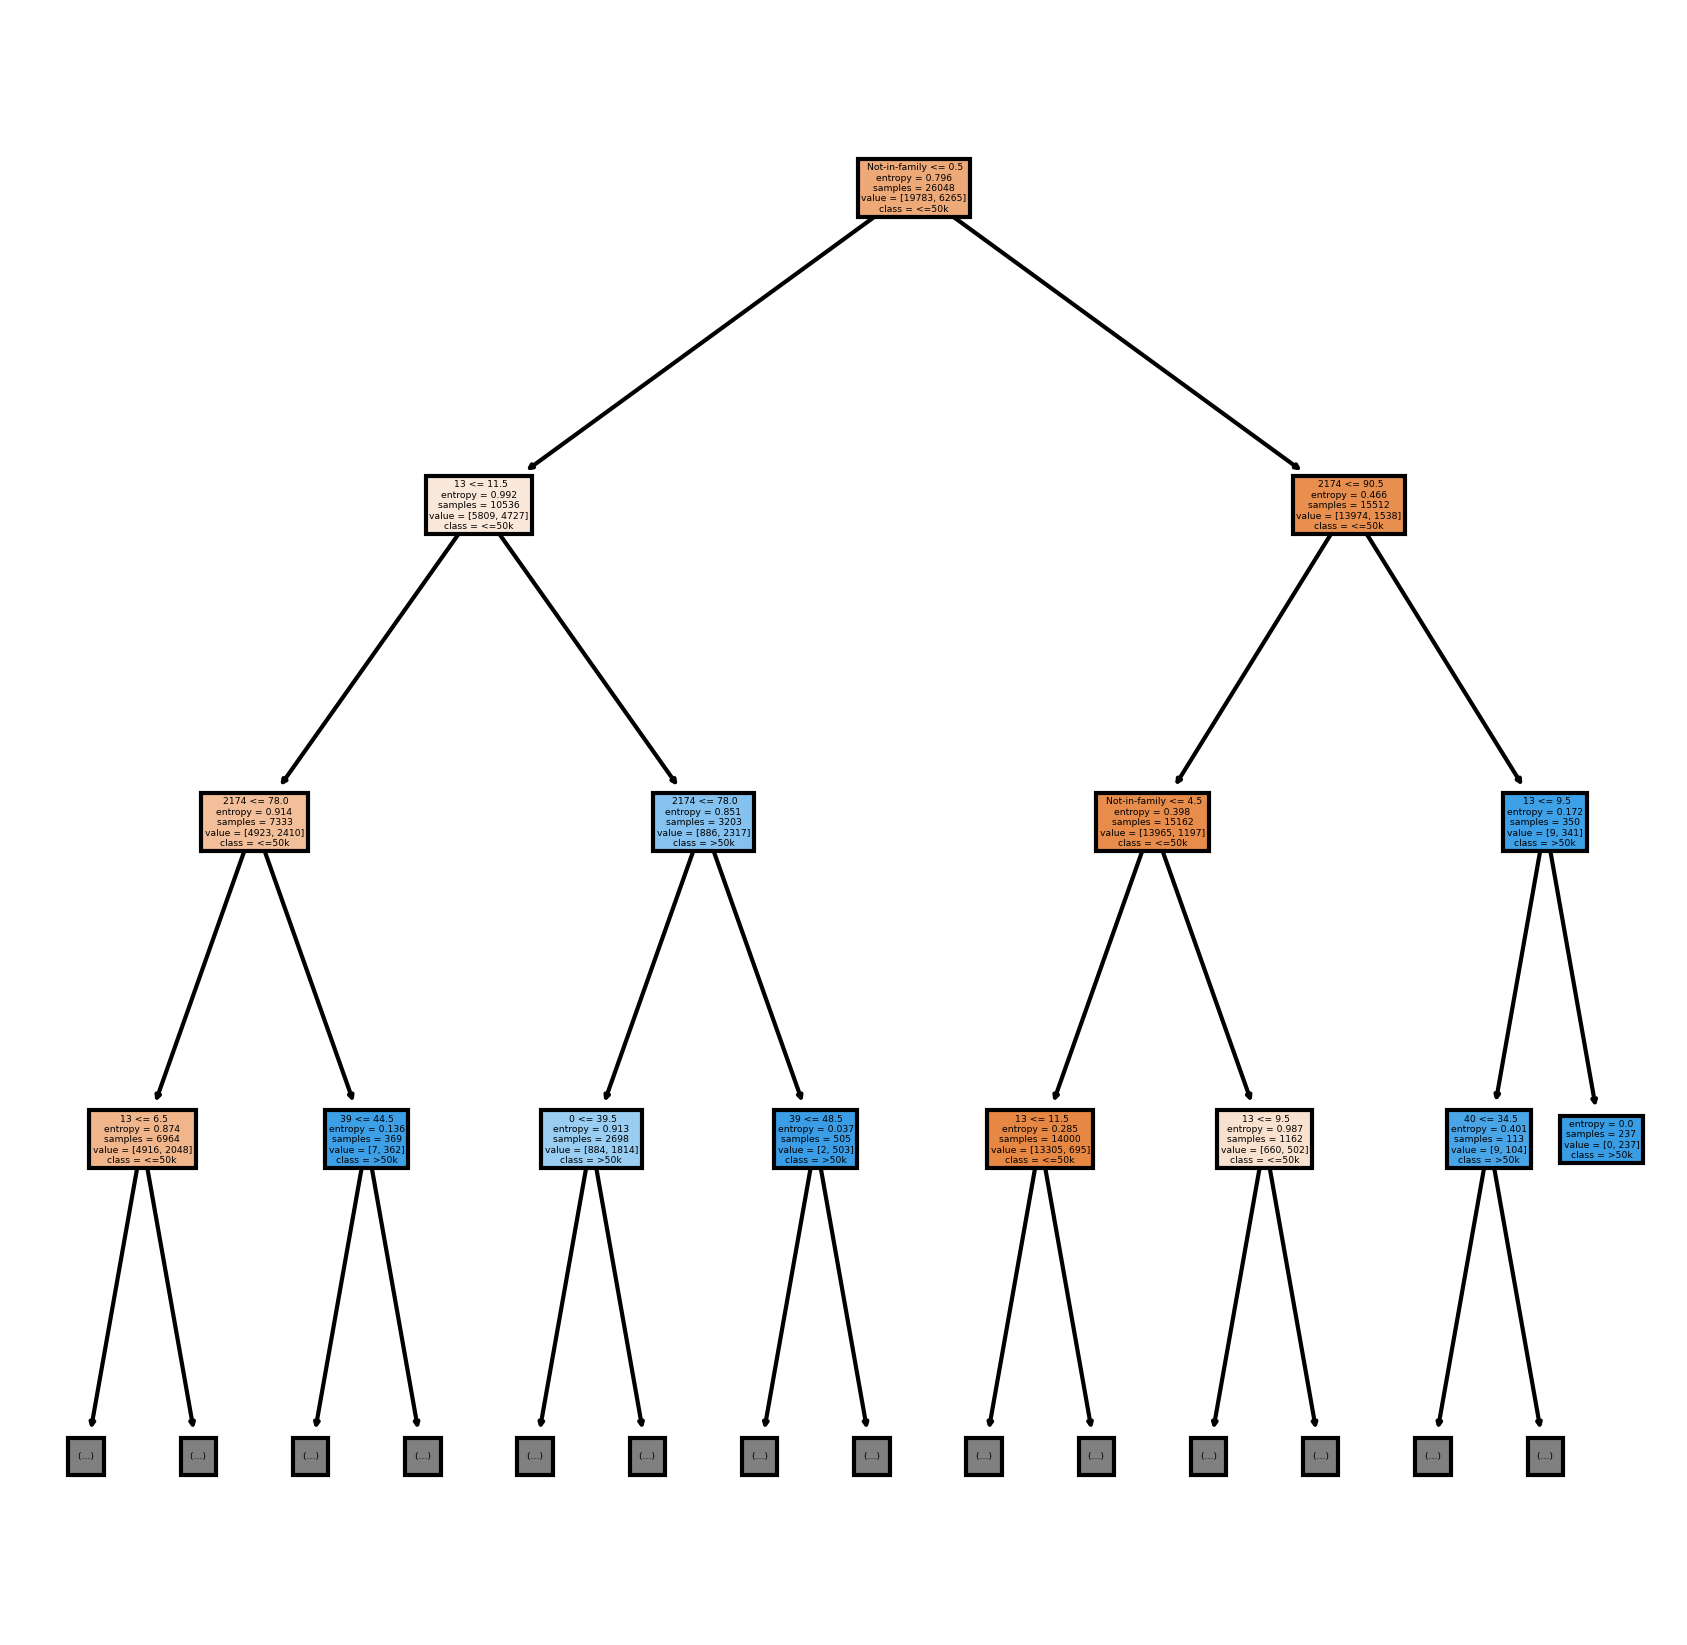

'\nThe output class of this dataset is either <=50k or >50k which tell us if a person makes more than 50k or less than 50k considering the features in the dataset.\nThere are 14 features in the data, and the feature that has the most information gain is "Not-in-family", so this feature is the best attribute or the best predictor for classification.\nAnd we can see that "13" and "2174" are the next best attribute to split on, and so on.\n'

In [17]:
# Include decision tree visualization here
from sklearn import tree

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,7), dpi=300)
tree.plot_tree(clf2, filled=True, max_depth=3, class_names=['<=50k','>50k'], feature_names=adult_df.columns[:-1])
plt.show()
# Discuss what the model has learned
'''
The output class of this dataset is either <=50k or >50k which tell us if a person makes more than 50k or less than 50k considering the features in the dataset.
There are 14 features in the data, and the feature that has the most information gain is "Not-in-family", so this feature is the best attribute or the best predictor for classification.
And we can see that "13" and "2174" are the next best attribute to split on, and so on.
'''

## 7. (optional 5% extra credit) Implement reduced error pruning to help avoid overfitting.  
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).